# Object Detection using RetinaNet

RetinaNet is a neural network architecture for object detection described in [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002) by Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He and Piotr Dollár.

The following shows how to use a [Keras based implementation](https://github.com/fizyr/keras-retinanet) along with model parameters pretrained on the [COCO object detection dataset](http://cocodataset.org/).

In [ ]:
%pip install -q keras-retinanet

## Loading a Pretrained Keras Model

In [1]:
from urllib.request import urlretrieve
import os

PRETRAINED_MODEL_NAME = "resnet50_coco_best_v2.1.0.h5"
BACKBONE_NAME = 'resnet50'
PRETRAINED_BASE_URL = (
    "https://github.com/fizyr/keras-retinanet/"
    "releases/download/0.5.1/")

if not os.path.exists(PRETRAINED_MODEL_NAME):
    model_url = PRETRAINED_BASE_URL + PRETRAINED_MODEL_NAME
    print(f"Downloading {model_url}...")
    urlretrieve(model_url, PRETRAINED_MODEL_NAME)
    print("done.")

In [2]:
ls -lh *.h5

 Volume in drive C is Windows
 Volume Serial Number is F462-B076

 Directory of C:\Users\dernh\JUPYTER\DeepLearningApplied\lectures-labs\labs\01_keras


 Directory of C:\Users\dernh\JUPYTER\DeepLearningApplied\lectures-labs\labs\01_keras

01/21/2022  10:45 AM       152,662,144 resnet50_coco_best_v2.1.0.h5
               1 File(s)    152,662,144 bytes
               0 Dir(s)  17,333,870,592 bytes free


In [3]:
from keras_retinanet import models

# load retinanet model
model = models.load_model(PRETRAINED_MODEL_NAME, backbone_name=BACKBONE_NAME)

In [4]:
# print(model.summary())

## Detecting Objects (Location and Classes) in Test Images

We need to define a label to names mapping for visualization purposes: those labels match the classes from the COCO dataset:

In [5]:
labels_to_names = {
    0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane',
    5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light',
    10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench',
    14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow',
    20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack',
    25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee',
    30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite',
    34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard',
    37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass',
    41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl',
    46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli',
    51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake',
    56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed',
    60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse',
    65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave',
    69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book',
    74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear',
    78: 'hair drier', 79: 'toothbrush'}

shape: (800, 1067, 3), dtype: float32, range: (-123.68, 255)
processing time: 0.5s
person 0.912
keyboard 0.835
cell phone 0.664
book 0.495
chair 0.471


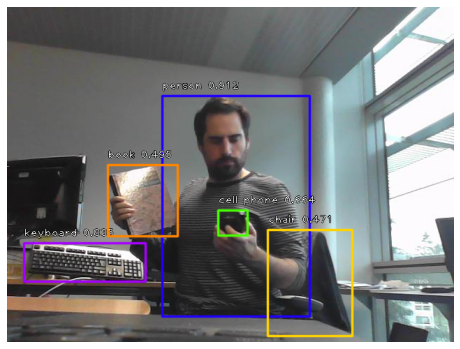

In [7]:
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import time
import cv2
import numpy as np


def detect_and_visualize(image_bgr):
    # copy to draw on
    draw = image_bgr.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image_input = image_bgr.copy()
    image_input = preprocess_image(image_input)
    image_input, scale = resize_image(image_input)
    print(f"shape: {image_input.shape}, dtype: {image_input.dtype}, "
          f"range: {(image_input.min(), image.max())}")

    # process image (batch_size=1)
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(
        np.expand_dims(image_input, axis=0))
    print(f"processing time: {time.time() - start:.1f}s")

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.4:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        print(caption)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(draw)
    

# load image
image = read_image_bgr('webcam_shot.jpeg')
detect_and_visualize(image)

## Real World Data

Let's play with the laptop webcam:

In [11]:
import cv2
from keras_retinanet.utils.image import read_image_bgr
import matplotlib.pyplot as plt

def camera_grab(camera_id=0, fallback_filename='webcam_shot.jpeg'):
    camera = cv2.VideoCapture(camera_id)
    try:
        # take 10 consecutive snapshots to let the camera automatically tune
        # itself and hope that the contrast and lightning of the last snapshot
        # is good enough.
        for i in range(10):
            snapshot_ok, image = camera.read()
        if not snapshot_ok:
            print("WARNING: could not access camera")
            if fallback_filename:
                image = read_image_bgr(fallback_filename)
    finally:
        camera.release()
    return image

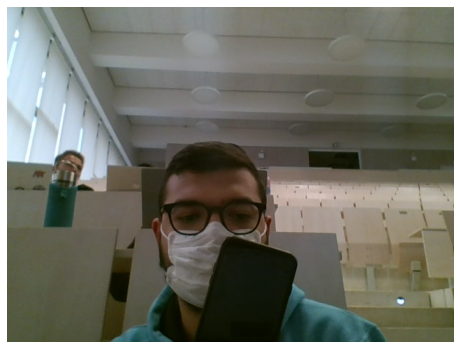

In [14]:
image = camera_grab(camera_id=0)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off');

shape: (800, 1067, 3), dtype: float32, range: (-123.68, 255)
processing time: 0.3s
person 0.894
chair 0.551
chair 0.470
laptop 0.439


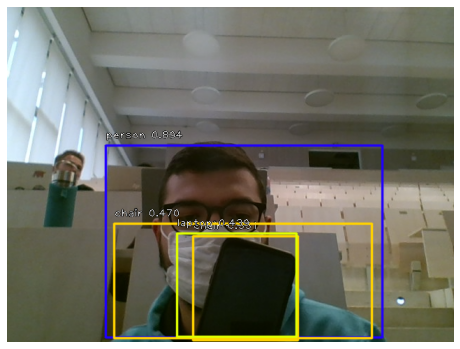

In [15]:
detect_and_visualize(image)